In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import copy
from math import sqrt,ceil

from clyent import color
from scipy.stats import linregress
import libraries as lib

In [13]:
#Lees de GPS data in

# Helper function to convert NMEA latitude/longitude to decimal degrees
def convert_to_decimal_degrees(value, direction):
    degrees = int(value) // 100
    minutes = value - (degrees * 100)
    decimal = degrees + (minutes / 60)
    
    if direction in ['S', 'W']:
        decimal = -decimal
    
    return decimal

# Function to read GPS data from a text file and convert to a DataFrame
def lees_gps_data(filepath):
    """Read GPS data from a text file and convert to a DataFrame."""
    timestamps = []
    latitudes = []
    lat_directions = []
    longitudes = []
    lon_directions = []
    hoogtes = []
    speeds = []
    
    with open(filepath, 'r') as file:
        for regel in file:
            parts = regel.split(',')
            if regel.startswith('$GPRMC'):
                # Extract time and speed from GPRMC sentence
                if len(parts) > 7:
                    timestamp = parts[1]
                    speed = parts[7]  # Speed in knots
                    timestamps.append(timestamp)
                    try:
                        speed_kmh = (float(speed) * 1.852) / 3.6  # Convert knots to m/s
                        speeds.append(speed_kmh)
                    except ValueError:
                        speeds.append(None)

            elif regel.startswith('$GPGGA'):
                # Extract latitude, longitude, and altitude from GPGGA sentence
                if len(parts) > 9:
                    latitude = parts[2]
                    lat_direction = parts[3]
                    longitude = parts[4] 
                    lon_direction = parts[5]
                    altitude = parts[9]
                    
                    # Append raw values for conversion later
                    try:
                        latitude = float(latitude)
                        latitudes.append(latitude)
                        lat_directions.append(lat_direction)
                    except ValueError:
                        latitudes.append(None)
                        lat_directions.append(None)
                    
                    try:
                        longitude = float(longitude)
                        longitudes.append(longitude)
                        lon_directions.append(lon_direction)
                    except ValueError:
                        longitudes.append(None)
                        lon_directions.append(None)
                    
                    # Convert altitude to float
                    try:
                        altitude = float(altitude)
                        hoogtes.append(altitude)
                    except ValueError:
                        hoogtes.append(None)
    
    # Check if all lists have the same length
    max_length = max(len(timestamps), len(latitudes), len(longitudes), len(hoogtes), len(speeds))
    
    # Make sure all lists have the same length by appending None to the shorter ones
    timestamps.extend([None] * (max_length - len(timestamps)))
    latitudes.extend([None] * (max_length - len(latitudes)))
    lat_directions.extend([None] * (max_length - len(lat_directions)))
    longitudes.extend([None] * (max_length - len(longitudes)))
    lon_directions.extend([None] * (max_length - len(lon_directions)))
    hoogtes.extend([None] * (max_length - len(hoogtes)))
    speeds.extend([None] * (max_length - len(speeds)))
    
    # Construct DataFrame
    data = {
        'timestamp': timestamps,
        'latitude': latitudes,
        'lat_direction': lat_directions,
        'longitude': longitudes,
        'lon_direction': lon_directions,
        'hoogte': hoogtes,
        'speed_m/s': speeds
    }
    
    df = pd.DataFrame(data)
    
    # Filter out rows where latitude or longitude are missing
    df = df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
    
    # Convert latitude and longitude columns to decimal degrees
    df['latitude'] = df.apply(lambda row: convert_to_decimal_degrees(float(row['latitude']), row['lat_direction']), axis=1)
    df['longitude'] = df.apply(lambda row: convert_to_decimal_degrees(float(row['longitude']), row['lon_direction']), axis=1)
    
    return df

# Set file path
file_path = "/Users/willemheemskerk/Downloads/20230525_h2a_poging1/0002/Data voor hoogteprofiel.txt"

# Read GPS data
df = lees_gps_data(file_path)

# Print the resulting DataFrame
df


,timestamp,latitude,lat_direction,longitude,lon_direction,hoogte,speed_m/s
0,063448.30,43.771393,N,-0.042098,W,99.5,0.038583
1,063448.40,43.771393,N,-0.042098,W,99.5,0.026237
2,063448.50,43.771393,N,-0.042098,W,99.4,0.035497
3,063448.60,43.771393,N,-0.042098,W,99.5,0.073051
4,063448.70,43.771393,N,-0.042098,W,99.4,0.064820
...,...,...,...,...,...,...,...
46568,None,43.771202,N,-0.041941,W,96.0,NaN
46569,None,43.771202,N,-0.041941,W,96.0,NaN
46570,None,43.771202,N,-0.041941,W,96.1,NaN
46571,None,43.771202,N,-0.041941,W,96.1,NaN


In [17]:
directory = "/Users/willemheemskerk/Downloads/20230525_h2a_poging1/0002/"
file_master = "1.csv"
file_motordriver ="5.csv"
file_FCC = "4.csv"
file_richting = "F.csv"
data_file_motordriver = lib.DataInladenMotorDriver(f'{directory}{file_motordriver}')
data_file_master = lib.DataInladen(f'{directory}{file_master}')
data_file_FCC = lib.DataInladenFCC(f'{directory}{file_FCC}')
data_file_richting = lib.DataInladen(f'{directory}{file_richting}')

In [28]:
#Filter motordriver data van race begin tot race einde

def filter_track_data_with_start_and_end(data_file_motordriver, start_row, end_row):
    """
    Filter de data handmatig vanaf een opgegeven startrij tot een opgegeven eindrij.
    
    Parameters:
        data_file_motordriver (DataFrame): Het originele DataFrame.
        start_row (int): Het indexnummer van de rij waarmee het filteren moet beginnen.
        end_row (int): Het indexnummer van de rij waarmee het filteren moet eindigen.
        
    Returns:
        DataFrame: Het gefilterde DataFrame vanaf start_row tot end_row.
    """
    # Zorg ervoor dat de start_row en end_row binnen de geldige indexrange vallen
    if start_row < 0 or start_row >= len(data_file_motordriver):
        raise ValueError("De opgegeven start-row valt buiten de geldige indexrange.")
    if end_row < 0 or end_row >= len(data_file_motordriver):
        raise ValueError("De opgegeven end-row valt buiten de geldige indexrange.")
    
    # Controleer dat start_row kleiner of gelijk is aan end_row
    if start_row > end_row:
        raise ValueError("De start-row moet kleiner zijn dan of gelijk zijn aan de eind-row.")
    
    # Filter het DataFrame tussen start_row en end_row
    return data_file_motordriver.iloc[start_row:end_row + 1]

# Handmatige specificatie van start- en eindrij
start_row = 223257  # Begin vanaf rij 223257
end_row = 479444    # Eindig bij rij 250000

# Filter de data
filtered_motordriver = filter_track_data_with_start_and_end(data_file_motordriver, start_row, end_row)

# Print het gefilterde DataFrame
filtered_motordriver


,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,Huidig stroom-instelpunt van cruise control,Doelsnelheid van cruise control,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum
223257,5,4540.1490,03|04,898.7554,2.689,9.883,36.8,-1340,31.898,1.225,...,0,0.000,0,0.000,0.000689,0.062849,333.0,1.7,73857.4,NaN
223258,5,4540.1571,03|04,898.7634,3.127,10.037,43.2,-1340,31.894,1.325,...,0,0.000,0,0.000,0.000689,0.062849,333.0,1.7,73857.4,NaN
223259,5,4540.1652,03|04,898.7716,3.702,10.203,51.8,-1339,31.889,1.454,...,0,0.000,0,0.000,0.000689,0.062849,339.2,1.7,73857.6,NaN
223260,5,4540.1734,03|04,898.7796,3.541,10.329,50.1,-1339,31.889,1.499,...,0,0.000,0,0.000,0.000689,0.062849,339.2,1.7,73857.6,NaN
223261,5,4540.1815,03|04,898.7878,3.242,10.222,46.2,-1339,31.894,1.391,...,0,0.000,0,0.000,0.000689,0.062849,339.2,1.7,73857.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479440,5,6774.8277,03|04,3133.0471,0.021,-0.085,-0.0,181490,30.445,-0.039,...,2,20.833,0,3073.986,0.000686,0.062844,323.4,3.0,81612.0,NaN
479441,5,6774.8364,03|04,3133.0559,0.020,-0.084,-0.0,181490,30.445,-0.042,...,2,20.833,0,3073.986,0.000686,0.062844,323.4,3.0,81612.0,NaN
479442,5,6774.8451,03|04,3133.0647,0.020,-0.084,-0.0,181490,30.445,-0.045,...,2,20.833,0,3073.986,0.000686,0.062844,323.4,3.0,81612.0,NaN
479443,5,6774.8538,03|04,3133.0735,0.020,-0.083,-0.0,181490,30.445,-0.048,...,2,20.833,0,3073.986,0.000686,0.062844,323.4,3.0,81612.0,NaN


In [29]:
# Functie om graden minuten naar decimale graden om te rekenen
def convert_to_decimal_degrees(value):
    if pd.isna(value):
        return None
    degrees = int(value // 100)  # De gehele gradenwaarde
    minutes = value % 100  # De minutenwaarde
    decimal_degrees = degrees + (minutes / 60)
    return decimal_degrees

# Pas de functie toe op latitude en longitude kolommen, waarbij NaN-waarden worden behouden
filtered_motordriver['GPS latitude, in graden'] = filtered_motordriver['GPS latitude, in graden'].apply(lambda x: convert_to_decimal_degrees(x) if pd.notna(x) else None)
filtered_motordriver['GPS longitude, in graden'] = filtered_motordriver['GPS longitude, in graden'].apply(lambda x: -convert_to_decimal_degrees(abs(x)) if pd.notna(x) and x < 0 else convert_to_decimal_degrees(x) if pd.notna(x) else None)

filtered_motordriver

/var/folders/4x/syjxsxb92jb63fywzwb8mgvh0000gn/T/ipykernel_84733/2689420534.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_motordriver['GPS latitude, in graden'] = filtered_motordriver['GPS latitude, in graden'].apply(lambda x: convert_to_decimal_degrees(x) if pd.notna(x) else None)
/var/folders/4x/syjxsxb92jb63fywzwb8mgvh0000gn/T/ipykernel_84733/2689420534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_motordriver['GPS longitude, in graden'] = filtered_motordriver['GPS longitu

,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,Huidig stroom-instelpunt van cruise control,Doelsnelheid van cruise control,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum
223257,5,4540.1490,03|04,898.7554,2.689,9.883,36.8,-1340,31.898,1.225,...,0,0.000,0,0.000,0.000011,0.001047,333.0,1.7,73857.4,NaN
223258,5,4540.1571,03|04,898.7634,3.127,10.037,43.2,-1340,31.894,1.325,...,0,0.000,0,0.000,0.000011,0.001047,333.0,1.7,73857.4,NaN
223259,5,4540.1652,03|04,898.7716,3.702,10.203,51.8,-1339,31.889,1.454,...,0,0.000,0,0.000,0.000011,0.001047,339.2,1.7,73857.6,NaN
223260,5,4540.1734,03|04,898.7796,3.541,10.329,50.1,-1339,31.889,1.499,...,0,0.000,0,0.000,0.000011,0.001047,339.2,1.7,73857.6,NaN
223261,5,4540.1815,03|04,898.7878,3.242,10.222,46.2,-1339,31.894,1.391,...,0,0.000,0,0.000,0.000011,0.001047,339.2,1.7,73857.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479440,5,6774.8277,03|04,3133.0471,0.021,-0.085,-0.0,181490,30.445,-0.039,...,2,20.833,0,3073.986,0.000011,0.001047,323.4,3.0,81612.0,NaN
479441,5,6774.8364,03|04,3133.0559,0.020,-0.084,-0.0,181490,30.445,-0.042,...,2,20.833,0,3073.986,0.000011,0.001047,323.4,3.0,81612.0,NaN
479442,5,6774.8451,03|04,3133.0647,0.020,-0.084,-0.0,181490,30.445,-0.045,...,2,20.833,0,3073.986,0.000011,0.001047,323.4,3.0,81612.0,NaN
479443,5,6774.8538,03|04,3133.0735,0.020,-0.083,-0.0,181490,30.445,-0.048,...,2,20.833,0,3073.986,0.000011,0.001047,323.4,3.0,81612.0,NaN


In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2)

def find_nearest_index(df, target_lon, target_lat):
    distances = df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], target_lat, target_lon), axis=1)
    return distances.idxmin()

def filter_track_data(df, start_lon, start_lat, end_lon, end_lat):
    start_index = find_nearest_index(df, start_lon, start_lat)
    end_index = find_nearest_index(df, end_lon, end_lat)
    
    # Zorg ervoor dat de start_index voor de end_index komt
    if start_index > end_index:
        start_index, end_index = end_index, start_index
    
    return df.iloc[start_index:end_index + 1]

In [21]:
#Filter vanaf het moment dat de auto de baan opgaat en wanneer die er weer afgaat.

# Definieer de coördinaten voor het start- en eindpunt
start_lon = -0.0446
start_lat = 0.00095 + 4.3771e1
end_lon = -0.039925
end_lat = 0.000300 + 4.3771e1

# Veronderstel dat 'df' je DataFrame is met de relevante data
filtered_df = filter_track_data(df, start_lon, start_lat, end_lon, end_lat)

# Print het gefilterde DataFrame om te controleren
filtered_df
#43.767914, -0.035855

,timestamp,latitude,lat_direction,longitude,lon_direction,hoogte,speed_m/s
22340,071203.60,43.771951,N,-0.044597,W,102.0,5.597156
22341,071203.70,43.771954,N,-0.044603,W,102.0,5.624421
22342,071203.80,43.771955,N,-0.044609,W,102.0,5.633167
22343,071203.90,43.771958,N,-0.044616,W,102.0,5.650143
22344,071204.00,43.771960,N,-0.044622,W,102.0,5.655288
...,...,...,...,...,...,...,...
42943,074720.40,43.771037,N,-0.040149,W,98.1,8.270209
42944,074720.50,43.771032,N,-0.040142,W,98.1,8.298503
42945,074720.60,43.771027,N,-0.040135,W,98.1,8.276382
42946,074720.70,43.771022,N,-0.040127,W,98.1,8.287700


In [5]:
# Versnelling berekenen met behulp van het verschil in snelheid en tijd
dt = data_file_motordriver.iloc[:, 1]
dsnelheid = data_file_motordriver.iloc[:, 30] /3.6  # Omrekenen van km/h naar m/s

# Nieuwe kolom toevoegen aan dataframe
data_file_motordriver['Versnelling (m/s**2)'] = dsnelheid/dt

data_file_motordriver

,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,Doelsnelheid van cruise control,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum,Versnelling (m/s**2)
0,5,252.6246,03|04,0.0060,2.725,-0.003,-0.1,0,3.034,-0.000,...,0.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,252.6305,03|04,0.0118,4.996,-0.006,-0.1,0,5.562,0.008,...,0.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,252.6362,03|04,0.0176,7.028,-0.008,-0.2,0,7.823,0.018,...,0.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,252.6420,03|04,0.0234,8.845,-0.010,-0.2,0,9.846,0.028,...,0.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,252.6478,03|04,0.0292,10.471,-0.010,-0.2,0,11.655,0.033,...,0.000,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496050,5,6919.3279,03|04,3277.5222,0.039,0.114,0.0,181490,9.762,0.111,...,20.833,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000060
496051,5,6919.3363,03|04,3277.5308,0.039,0.122,0.0,181490,9.371,0.114,...,20.833,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000060
496052,5,6919.3448,03|04,3277.5393,0.040,0.129,0.0,181490,8.970,0.119,...,20.833,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000060
496053,5,6919.3533,03|04,3277.5479,0.040,0.141,0.0,181490,8.543,0.124,...,20.833,0,3073.986,-2.4680,4346.2451,228.6,1.5,81836.6,NaN,0.000060


In [6]:
gevonden = False
finish_rijen = np.array([])

lat_min, lat_max = -2.4250, -2.4225
lon_min, lon_max = 0.226+4.346e3,0.237+4.346e3 

# Kolomnamen
yas = 'GPS latitude, in graden'
xas = 'GPS longitude, in graden'
afstand_rondje = 1588.84925219  # Afstand van een rondje in meters

# Filter rows where latitude, longitude, and the distance are non-zero
data_file_motordriver = data_file_motordriver[data_file_motordriver[xas] != 0]
data_file_motordriver = data_file_motordriver[data_file_motordriver[yas] != 0]
data_file_motordriver = data_file_motordriver[data_file_motordriver['Afgelegde afstand sinds laatste herstart motordriver (m)'] != 0]

# Itereer over elke rij in de DataFrame
for i in range(len(data_file_motordriver)):
    lat = data_file_motordriver[xas].iloc[i]  # Latitude van de i-de rij
    lon = data_file_motordriver[yas].iloc[i]  # Longitude van de i-de rij
    afstand = data_file_motordriver["Afgelegde afstand sinds laatste herstart motordriver (m)"].iloc[i]

    # Controleer of het punt binnen het vierkant valt
    if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
        if not gevonden:  # Voeg alleen toe als dit de eerste keer is dat we het punt vinden
            finish_rijen = np.append(finish_rijen, i)
            gevonden = True  # Vlag op 'gevonden' zetten
            start_afstand = afstand  # Opslaan van de startafstand bij het eerste punt

    # Controleer of de afgelegde afstand groter is dan een volledige ronde
    if gevonden and afstand >= start_afstand + (afstand_rondje * (len(finish_rijen))):
        finish_rijen = np.append(finish_rijen, i)

print(finish_rijen)
afstanden = np.array([])  # Maak een lege array voor afstanden


[186406. 209641. 234548. 260355. 284887. 310007. 334643. 360363. 386167.
 415649.]


In [7]:
begin_eind_paren2 = [
    (0, 186406), 
    (186406, 209641), 
    (209641, 234548), 
    (234548, 260355),
    (260355, 284887), 
    (284887, 310007), 
    (310007, 334643), 
    (334643, 360363),
    (360363, 386167), 
    (386167, 415649)
]

# Maak een lege lijst om de rondes-dataframes op te slaan
rondes = []


# Loop door elke (begin, eind) paar en maak een DataFrame subset
for i, (begin, eind) in enumerate(begin_eind_paren2):
    df_segment = data_file_motordriver.iloc[begin:eind]
    rondes.append(df_segment)

# Je kunt nu elke ronde benaderen als rondes[0], rondes[1], etc.
df_ronde1 = rondes[0]
df_ronde2 = rondes[1]
df_ronde3 = rondes[2]
df_ronde4 = rondes[3]
df_ronde5 = rondes[4]
df_ronde6 = rondes[5]
df_ronde7 = rondes[6]
df_ronde8 = rondes[7]
df_ronde9 = rondes[8]
df_ronde10 = rondes[9]

df_ronde4

,Datalogger port,"Dataloggertijd, in s",Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning aan de ingang van motordriver (V),Stroom door de ingang van motordriver (A),...,Doelsnelheid van cruise control,"Toestand cruise control2-knop (aan=1, uit=0)",Tijdstip laatste verandering cruise control2-knop,"GPS longitude, in graden","GPS latitude, in graden",GPS direction,"GPS speed, in km/h","GPS time, in seconden sinds het begin van de huidige GPS-week",Checksum,Versnelling (m/s**2)
297650,5,5179.4872,03|04,1537.9832,19.974,8.031,170.2,60377,28.594,6.098,...,22.959,0,1532.409,-2.4302,4346.2394,325.6,23.3,74936.8,NaN,0.001250
297651,5,5179.4960,03|04,1537.9918,20.097,8.081,172.8,60379,28.594,6.096,...,22.959,0,1532.409,-2.4302,4346.2394,325.6,23.3,74936.8,NaN,0.001250
297652,5,5179.5047,03|04,1538.0006,19.236,7.937,165.4,60380,28.592,6.100,...,22.959,0,1532.409,-2.4302,4346.2394,325.6,23.3,74936.8,NaN,0.001250
297653,5,5179.5135,03|04,1538.0094,19.573,8.014,169.1,60382,28.592,6.090,...,22.959,0,1532.409,-2.4302,4346.2394,325.6,23.3,74936.8,NaN,0.001250
297654,5,5179.5222,03|04,1538.0182,18.857,8.011,164.3,60383,28.591,6.105,...,22.959,0,1532.409,-2.4302,4346.2394,325.6,23.3,74936.8,NaN,0.001250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323452,5,5403.5042,03|04,1761.9614,19.927,8.016,172.1,78356,27.842,6.418,...,28.224,0,1738.094,-2.4346,4346.2436,324.2,24.8,75320.8,NaN,0.001275
323453,5,5403.5129,03|04,1761.9702,20.059,8.037,173.6,78357,27.840,6.427,...,28.224,0,1738.094,-2.4346,4346.2436,324.2,24.8,75320.8,NaN,0.001275
323454,5,5403.5217,03|04,1761.9788,19.922,8.008,172.8,78359,27.839,6.431,...,28.224,0,1738.094,-2.4346,4346.2436,324.2,24.8,75320.8,NaN,0.001275
323455,5,5403.5304,03|04,1761.9875,20.025,8.040,173.5,78360,27.837,6.434,...,28.224,0,1738.094,-2.4346,4346.2436,324.2,24.8,75320.8,NaN,0.001275


In [8]:
gevonden = False
rechtestuk_rijen = []

lat_min, lat_max = -2.4250, -2.4225
lon_min, lon_max = 0.226 + 4.346e3, 0.237 + 4.346e3

lat_min2, lat_max2 = -2.5488, -2.5478
lon_min2, lon_max2 = 0.001+4.34633e3,0.008+4.34633e3 
    
# Kolomnamen
yas = 'GPS latitude, in graden'
xas = 'GPS longitude, in graden'
afstand_rondje = 1588.84925219  # Afstand van een rondje in meters

# Filter rows where latitude, longitude, and the distance are non-zero
data_file_motordriver = data_file_motordriver[data_file_motordriver[xas] != 0]
data_file_motordriver = data_file_motordriver[data_file_motordriver[yas] != 0]
data_file_motordriver = data_file_motordriver[
    data_file_motordriver['Afgelegde afstand sinds laatste herstart motordriver (m)'] != 0]

# Itereer over elke rij in de DataFrame
for i in range(len(data_file_motordriver)):
    lat = data_file_motordriver[xas].iloc[i]  # Latitude van de i-de rij
    lon = data_file_motordriver[yas].iloc[i]  # Longitude van de i-de rij
   

    # Controleer of het punt binnen het vierkant valt
    if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
        if not gevonden:  # Voeg alleen toe als dit de eerste keer is dat we het punt vinden
            rechtestuk_rijen = np.append(rechtestuk_rijen, i)
            gevonden = True  # Vlag op 'gevonden' zetten

    # Controleer of de afgelegde afstand groter is dan een volledige ronde
    if gevonden and lat_min2 <= lat <= lat_max2 and lon_min2 <= lon <= lon_max2:
        rechtestuk_rijen = np.append(rechtestuk_rijen, i)
        gevonden = False
        
print(rechtestuk_rijen)
afstanden = np.array([])  # Maak een lege array voor afstanden


[186406. 190537. 209478. 213105. 234212. 238140. 259880. 263819. 284193.
 287975. 309006. 312888. 333483. 337587. 359110. 363725. 385116. 389256.]


In [9]:
# Begin- en eindwaarden in een lijst van tuples
begin_eind_paren = [
    (186406, 190537),
    (209478, 213105),
    (234212, 238140),
    (259880, 263819),
    (284193, 287975),
    (309006, 312888),
    (333483, 337587),
    (359110, 363725),
    (385116, 389256)
]

# Maak een lege lijst om de rechtestukken-dataframes op te slaan
rechtestukken = []

# Loop door elke (begin, eind) paar en maak een DataFrame subset
for i, (begin, eind) in enumerate(begin_eind_paren):
    df_segment = data_file_motordriver.iloc[begin:eind]
    rechtestukken.append(df_segment)

# Je kunt nu elk rechtestuk benaderen als rechtestukken[0], rechtestukken[1], etc.
# Of specifieker: df_recht1, df_recht2, etc.
df_recht1 = rechtestukken[0]
df_recht2 = rechtestukken[1]
df_recht3 = rechtestukken[2]
df_recht4 = rechtestukken[3]
df_recht5 = rechtestukken[4]
df_recht6 = rechtestukken[5]
df_recht7 = rechtestukken[6]
df_recht8 = rechtestukken[7]
df_recht9 = rechtestukken[8]


In [10]:
%matplotlib qt
# Plot voor elk rechte stuk maken
for idx, df_segment in enumerate(rechtestukken):
    # Filter de data voor alleen geldige waarden
    df_segment = df_segment[(df_segment['GPS longitude, in graden'] != 0) &
                            (df_segment['GPS latitude, in graden'] != 0) &
                            (df_segment['Wielsnelheid, in km/h'] != 0)]
    
    # Maak een figuur voor elk rechte stuk
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_segment['GPS longitude, in graden'], df_segment['GPS latitude, in graden'], 
                          c=df_segment['Wielsnelheid, in km/h'], cmap='viridis')
    
    # Titel en labels
    plt.title(f'GPS Data vs Speed - Rechte Stuk {idx + 1}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Kleurstaaf toevoegen
    cbar = plt.colorbar(scatter)
    cbar.set_label('Speed (km/h)')
    
    # Toon de plot in een nieuw venster
    plt.grid(True)
    plt.show()

# Maak een gecombineerde plot van alle rechte stukken
plt.figure(figsize=(12, 8))
for idx, df_segment in enumerate(rechtestukken):
    plt.scatter(df_segment['GPS longitude, in graden'], df_segment['GPS latitude, in graden'], label=f'Rechte Stuk {idx + 1}')

# Titel en labels voor de gecombineerde plot
plt.title('GPS Data vs Speed - Alle Rechte Stukken')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Voeg een legende toe
plt.legend()

# Toon de gecombineerde plot
plt.grid(True)
plt.show()

In [11]:
%matplotlib qt
# Plot voor elk rechte stuk maken
for idx, df_segment in enumerate(rechtestukken):
    # Filter de data voor alleen geldige waarden
    df_segment = df_segment[(df_segment['GPS longitude, in graden'] != 0) &
                            (df_segment['GPS latitude, in graden'] != 0) &
                            (df_segment['Wielsnelheid, in km/h'] != 0)]
    
    # Maak een figuur voor elk rechte stuk
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_segment['GPS longitude, in graden'], df_segment['GPS latitude, in graden'], 
                          c=df_segment['Wielsnelheid, in km/h'], cmap='viridis')
    
    # Titel en labels
    plt.title(f'GPS Data vs Speed - Rechte Stuk {idx + 1}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Kleurstaaf toevoegen
    cbar = plt.colorbar(scatter)
    cbar.set_label('Speed (km/h)')
    
    # Toon de plot in een nieuw venster
    plt.grid(True)
    plt.show()

# Maak een gecombineerde plot van alle rechte stukken
plt.figure(figsize=(12, 8))
for idx, df_segment in enumerate(rechtestukken):
    plt.scatter(df_segment['GPS longitude, in graden'], df_segment['GPS latitude, in graden'], label=f'Rechte Stuk {idx + 1}')

# Titel en labels voor de gecombineerde plot
plt.title('GPS Data vs Speed - Alle Rechte Stukken')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Voeg een legende toe
plt.legend()

# Toon de gecombineerde plot
plt.grid(True)
plt.show()

In [12]:
yas = 'GPS latitude, in graden'
xas = 'GPS longitude, in graden'
colorbar = 'Wielsnelheid, in km/h'
vermogen = 'Vermogen geleverd aan de motor (W)'
data_file_motordriver = data_file_motordriver[data_file_motordriver[xas] != 0]
data_file_motordriver = data_file_motordriver[data_file_motordriver[yas] != 0]
data_file_motordriver = data_file_motordriver[data_file_motordriver[vermogen] ==  0]

plt.figure(figsize=(20, 20))

# Plot the data (replace merged_df with data_file_motordriver)
plt.scatter(data_file_motordriver[xas], data_file_motordriver[yas])

# Set the plot title and axis labels
plt.title('GPS data vs speed')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# Add a colorbar with a label for the speed in km/h (assuming you have speed data in 'speed' column)
cbar = plt.colorbar()
cbar.set_label('Speed (km/h)')

plt.show()

/var/folders/4x/syjxsxb92jb63fywzwb8mgvh0000gn/T/ipykernel_84733/871826968.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 20))


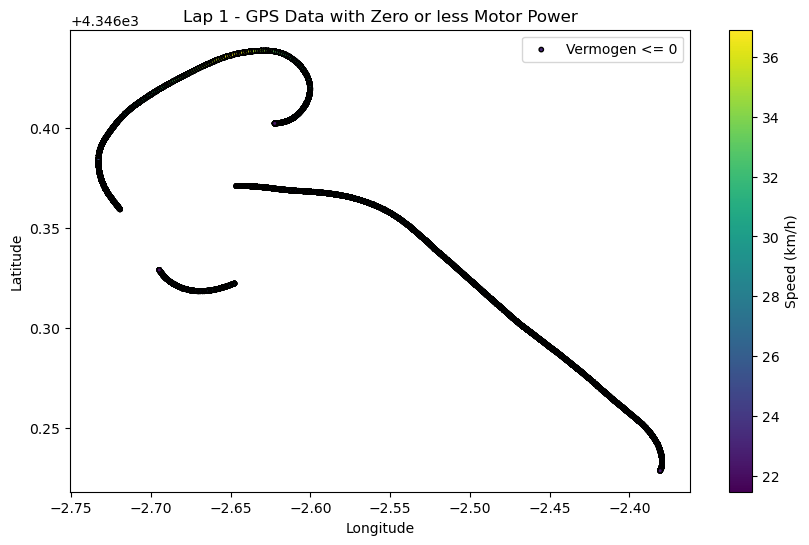

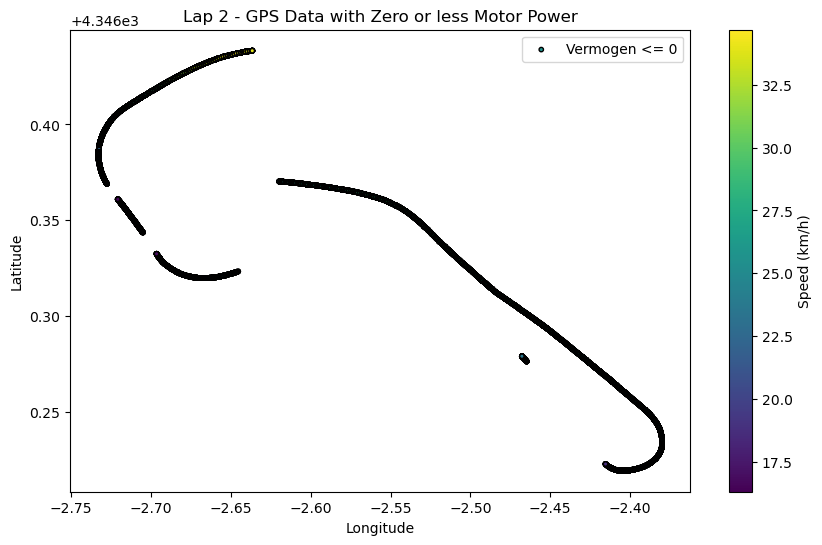

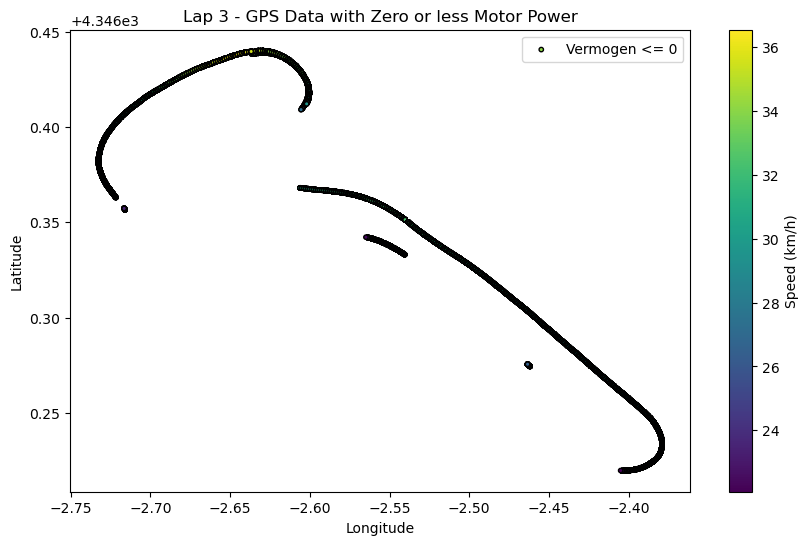

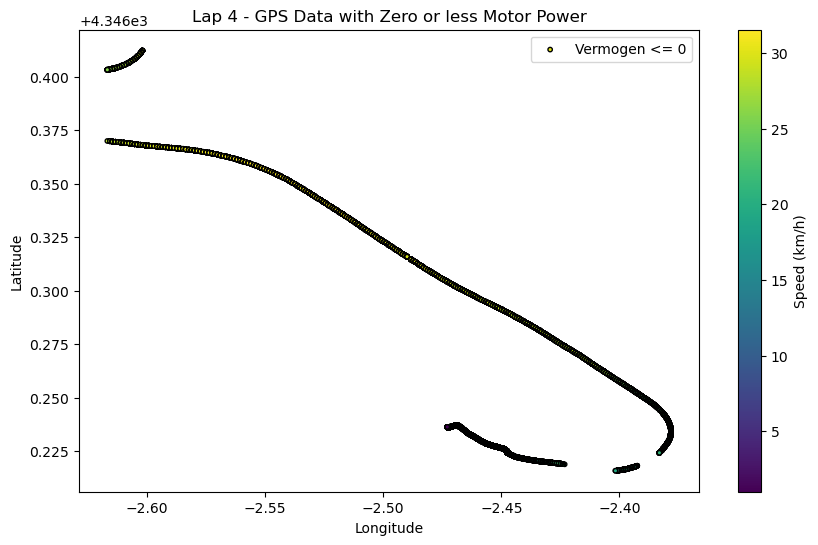

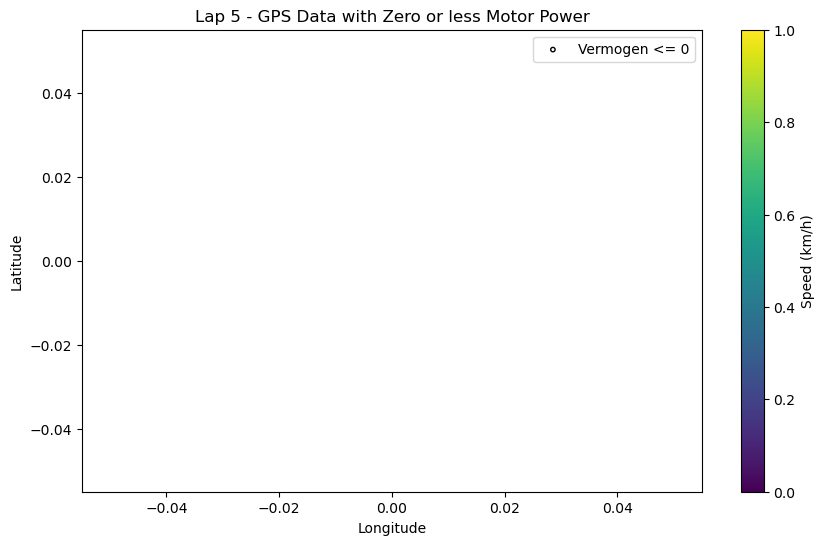

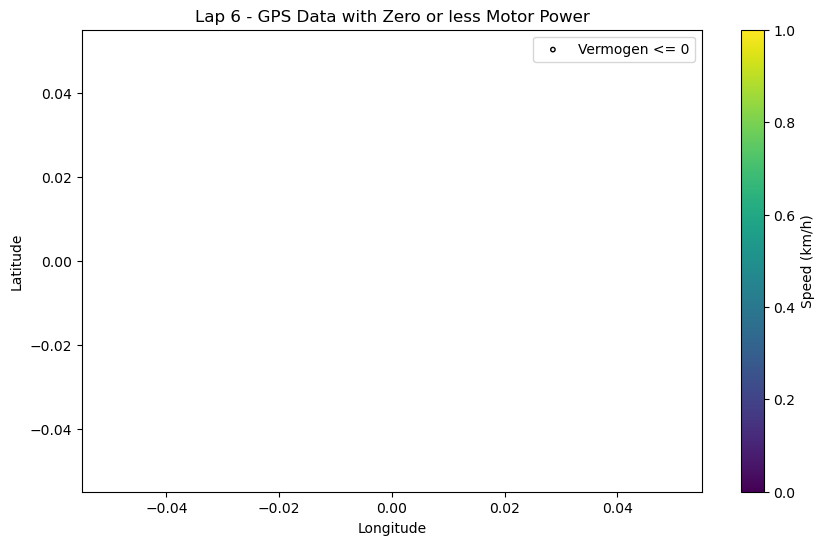

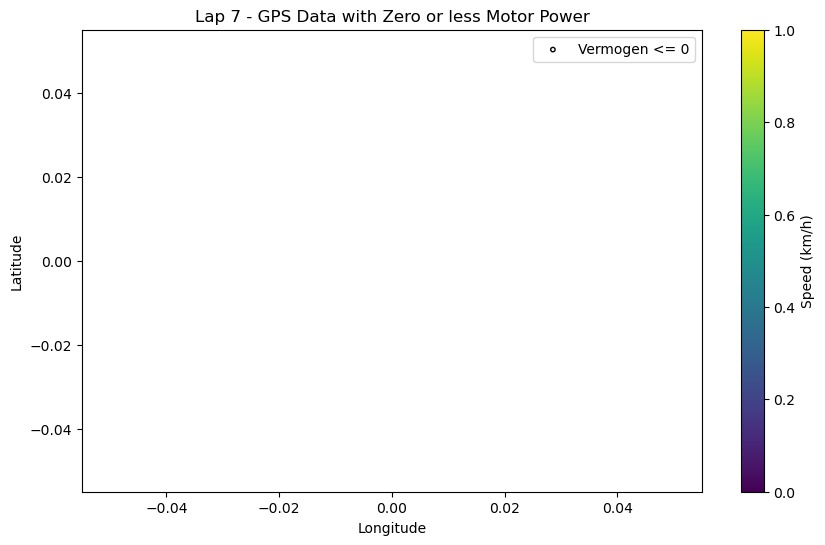

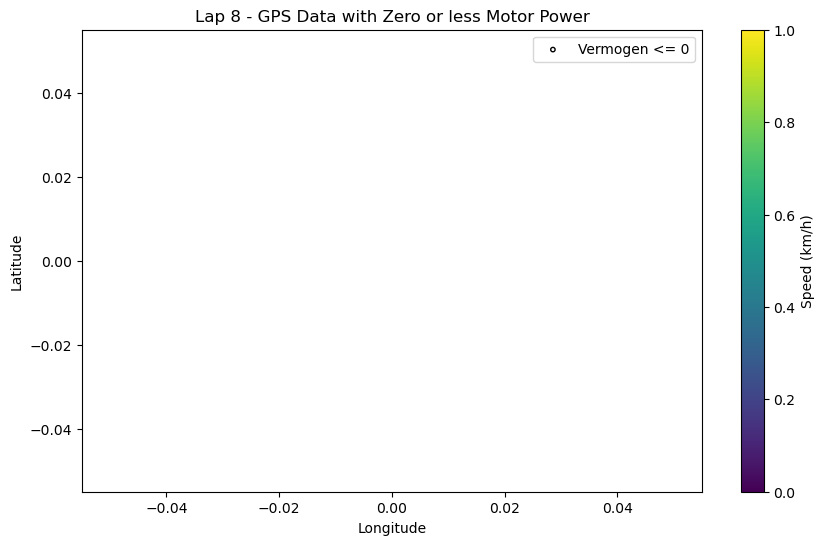

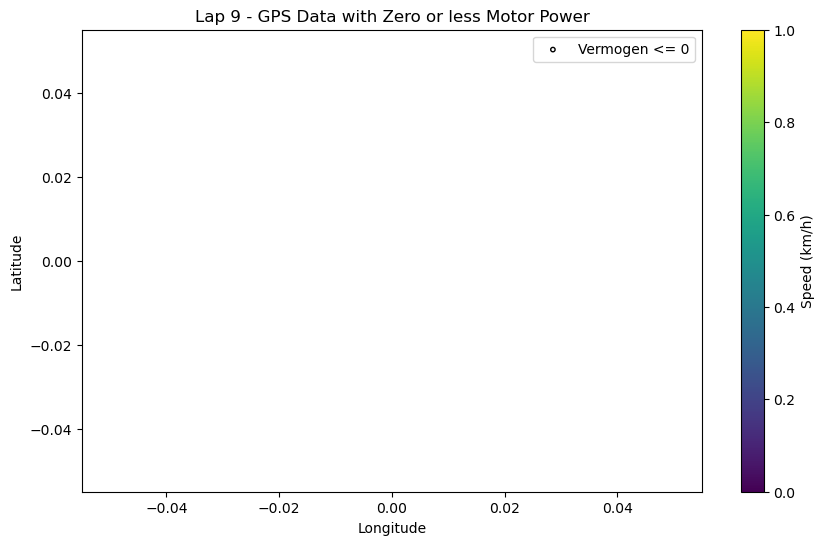

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

# Define axis labels for easy reference
yas = 'GPS latitude, in graden'
xas = 'GPS longitude, in graden'
colorbar = 'Wielsnelheid, in km/h'

# Filter out rows with zero values in specified columns for main data
data_file_motordriver = data_file_motordriver[
    (data_file_motordriver[xas] != 0) &
    (data_file_motordriver[yas] != 0) &
    (data_file_motordriver[colorbar] != 0)
]

# Ensure finish_rijen indices are integers
finish_rijen = [int(idx) for idx in finish_rijen]

# Loop through each lap using the finish line indices
for i in range(len(finish_rijen) - 1):
    # Define the start and end of the current lap
    start_idx = finish_rijen[i]
    end_idx = finish_rijen[i + 1]
    
    # Slice the data for the current lap
    lap_data = data_file_motordriver.iloc[start_idx:end_idx]

    # Filter for rows where motor power is zero or less
    zero_and_less_power_data = lap_data[lap_data["Vermogen geleverd aan de motor (W)"] <= 0]

    # Create scatter plot with color representing speed (colorbar variable)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        zero_and_less_power_data[xas],
        zero_and_less_power_data[yas],
        c= zero_and_less_power_data[colorbar],  # Map speed values to colors
        cmap='viridis',  # Choose a color map
        label='Vermogen <= 0',
        edgecolor='k',  # Optional: edge color for visibility
        s=10  # Optional: marker size
    )
    
    # Add color bar for speed
    cbar = plt.colorbar(scatter)
    cbar.set_label('Speed (km/h)')
    
    # Set labels and title for the current lap plot
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Lap {i + 1} - GPS Data with Zero or less Motor Power')
    plt.legend()
    plt.show()
